### Fonte do Dataframe
https://www.kaggle.com/datasets/adilashrafi/bank-marketing-classification-task 
https://www.kaggle.com/datasets/rubenssjr/brasilian-houses-to-rent 

###  Variáveis que vamos analisar
- city: Cidade onde está localizada o imóvel
- area: Área em m² do imóvel
- rooms: Quantidade de quartos
- bathroom: Quantidade de banheiros
- parking spaces: Quantidade de garagens
- floor: Andar da casa
- animal: Se permite ou não animal doméstico
- furniture: Se o imóvel está ou não mobiliado
- hoa (R$): Valor da taxa de condomínio
- rent amount (R$): Valor do aluguel
- property tax (R$): Valor do IPTU
- fire insurance (R$): Valor do seguro de incêncio
#### Alvo
- total (R$): Valor total de aluguel do imóvel 

  <div align="center">
 <h1> Bibliotecas Utilizadas 📖</h1>
 </div>

In [47]:
#Bibliotecas
# Tratamento de dados.
import pandas as pd  
import numpy as np   
from sklearn.preprocessing import StandardScaler

# Visualização de dados
import matplotlib as plot 
import seaborn as sns   #Criação de gráficos   
import matplotlib.pyplot as plt  
import plotly.express as px                       

# Desativando os avisos 
import warnings
warnings.filterwarnings("ignore")


#Modelo de Machine Leaning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Carregando os dados

- Irei desconsiderar duas colunas do dataframe, que são o número do andar e se permite animal ou não. Acredito que se estivesse trabalhando somente com dados de apartamento, seria uma variável analisada, mas como estamos falando de casas e apartamentos, não vejo muito sentido em analisar tal dados.

In [3]:
# Carregar dados especifícos.
dados_completos = pd.read_csv("houses_to_rent_v2.csv", usecols=["city", "area", "rooms", "bathroom", "parking spaces",
       "furniture", "hoa (R$)", "rent amount (R$)", "property tax (R$)",
       "fire insurance (R$)", "total (R$)"])

<div align="center">
 <h1> Manipulação e Visualização dos Dados 🔎&nbsp; </h1>
 </div>

### Visualizando 5 linhas aleatórias

In [4]:
dados_completos.sample(5)

,city,area,rooms,bathroom,parking spaces,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
4016,São Paulo,556,4,5,7,not furnished,0,7000,2059,106,9165
149,São Paulo,60,2,1,0,not furnished,0,1080,94,17,1191
4326,Rio de Janeiro,58,2,1,0,not furnished,515,1232,51,16,1814
7085,São Paulo,216,3,4,2,not furnished,3400,4675,870,60,9005
8053,São Paulo,100,2,2,0,not furnished,900,2000,63,26,2989


## Número de linhas e colunas

In [5]:
print("Número de colunas", dados_completos.shape[1])
print("Número de linhas", dados_completos.shape[0])

Número de colunas 11
Número de linhas 10692


### Quantidade de dados distintos dentro de cada coluna

In [6]:
dados_completos.nunique().sort_values() 

furniture                 2
city                      5
bathroom                 10
rooms                    11
parking spaces           11
fire insurance (R$)     216
area                    517
rent amount (R$)       1195
property tax (R$)      1243
hoa (R$)               1679
total (R$)             5751
dtype: int64

### Número de imóveis por cidade.

- Irei trabalhar com os dados de São Paulo, pois eles possuem uma base de dados maior, enquanto os outros três têm uma quantidade de dados bastante desproporcional em relação a São Paulo.

In [7]:
dados_completos["city"].value_counts()

city
São Paulo         5887
Rio de Janeiro    1501
Belo Horizonte    1258
Porto Alegre      1193
Campinas           853
Name: count, dtype: int64

### Filtrando por cidades.

In [8]:
sem_cidades = dados_completos.loc[dados_completos['city'] == 'São Paulo']
df = sem_cidades.drop("city", axis=1)
df.shape

(5887, 10)

In [9]:
df.columns

Index(['area', 'rooms', 'bathroom', 'parking spaces', 'furniture', 'hoa (R$)',
       'rent amount (R$)', 'property tax (R$)', 'fire insurance (R$)',
       'total (R$)'],
      dtype='object')

## Renomeando colunas para português e traduzindo os valores da coluna mobiliado.

In [10]:
# Dicionário de mapeamento para renomear as colunas
colunas_portugues ={
    'area': 'area',
    'rooms': 'quartos',
    'bathroom': 'banheiros',
    'parking spaces': 'vagas_estacionamento',
    'furniture': 'mobiliado',
    'hoa (R$)': 'taxa_condominio',
    'rent amount (R$)': 'valor_aluguel',
    'property tax (R$)': 'iptu',
    'fire insurance (R$)': 'seguro_incendio',
    'total (R$)': 'total',
}

# Novo Dataframe
df.rename(columns=colunas_portugues, inplace=True)

#Renomeando os valores da coluna mobiliado para português.
df["mobiliado"] = df["mobiliado"].replace({'not furnished': 'nao mobiliado', 'furnished': 'mobiliado'})

In [11]:
df.head()

,area,quartos,banheiros,vagas_estacionamento,mobiliado,taxa_condominio,valor_aluguel,iptu,seguro_incendio,total
0,70,2,1,1,mobiliado,2065,3300,211,42,5618
1,320,4,4,0,nao mobiliado,1200,4960,1750,63,7973
4,25,1,1,0,nao mobiliado,0,800,25,11,836
5,376,3,3,7,nao mobiliado,0,8000,834,121,8955
7,213,4,4,4,nao mobiliado,2254,3223,1735,41,7253


### Verificando se há números nulos.

In [12]:
df.isnull().sum()

area                    0
quartos                 0
banheiros               0
vagas_estacionamento    0
mobiliado               0
taxa_condominio         0
valor_aluguel           0
iptu                    0
seguro_incendio         0
total                   0
dtype: int64

### Criando uma coluna por metros quadrados, para identificar alguns outliers em relação o preço do metro quadrado.

In [13]:
df['preco_m2'] = df['total']/df['area'].round()

## Tipo das nossas variável.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5887 entries, 0 to 10691
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   area                  5887 non-null   int64  
 1   quartos               5887 non-null   int64  
 2   banheiros             5887 non-null   int64  
 3   vagas_estacionamento  5887 non-null   int64  
 4   mobiliado             5887 non-null   object 
 5   taxa_condominio       5887 non-null   int64  
 6   valor_aluguel         5887 non-null   int64  
 7   iptu                  5887 non-null   int64  
 8   seguro_incendio       5887 non-null   int64  
 9   total                 5887 non-null   int64  
 10  preco_m2              5887 non-null   float64
dtypes: float64(1), int64(9), object(1)
memory usage: 551.9+ KB


<div align="center">
 <h1>Análise univariada &nbsp; </h1>
 </div>


| Variável      | Classificação |               
|:------------- |:--------------|               
| Área          | Quantitativa Contínua               |
| Quartos     | Quantitativa Discreta           |
| Banheiros   | Quantitativa Discreta         |
| Vagas Estacionamento        | Quantitativa Discreta            |
| Mobiliado   | Qualitativa nominal             |
| Taxa Condominio  | Quantitativa contínua             |
| Valor Aluguel  | Quantitativa Contínua              |
| Iptu | Quantitativa Contínua              |
| Seguro Incêndio | Quantitativa Contínua              |
| Total| Quantitativa Contínua       |
| Preço M²| Quantitativa Contínua       |


### Dados estatísticos são muito importantes para nossa análise. Já podemos notar a presença de muitos outliers, especialmente ao observarmos o desvio padrão (std) e a diferença entre o primeiro quartil (Q1 - 25%) e o terceiro quartil (Q3 - 75%).

In [15]:
df.describe().round(2)

,area,quartos,banheiros,vagas_estacionamento,taxa_condominio,valor_aluguel,iptu,seguro_incendio,total,preco_m2
count,5887.00,5887.00,5887.00,5887.00,5887.00,5887.00,5887.00,5887.00,5887.00,5887.00
mean,158.90,2.56,2.47,1.88,1169.63,4652.79,495.70,62.43,6380.83,51.77
std,347.47,1.17,1.50,1.69,4076.46,3634.61,4153.62,50.07,7541.32,103.46
min,11.00,1.00,1.00,0.00,0.00,500.00,0.00,4.00,508.00,0.74
25%,59.00,2.00,1.00,1.00,0.00,2000.00,37.00,26.00,2631.00,29.28
50%,106.00,3.00,2.00,1.00,665.00,3400.00,170.00,45.00,4596.00,41.69
75%,212.00,3.00,4.00,3.00,1608.50,6000.00,550.00,83.00,8591.00,61.39
max,24606.00,10.00,10.00,12.00,220000.00,45000.00,313700.00,677.00,316900.00,7545.24


### Com o gráfico de dispersão ou até mesmo o de caixa (nesses caso optei pelo de dispersão), podemos identificar outliers com mais facilidade visual. Os outliers são representados como bolinhas azuis que estão muito acima das outras. O padrão normal seria uma dispersão mais equilibrada entre o valor do aluguel e o seguro incêndio, com valores mais distribuídos. Irei filtrar esses outliers para verificarmos a diferença.

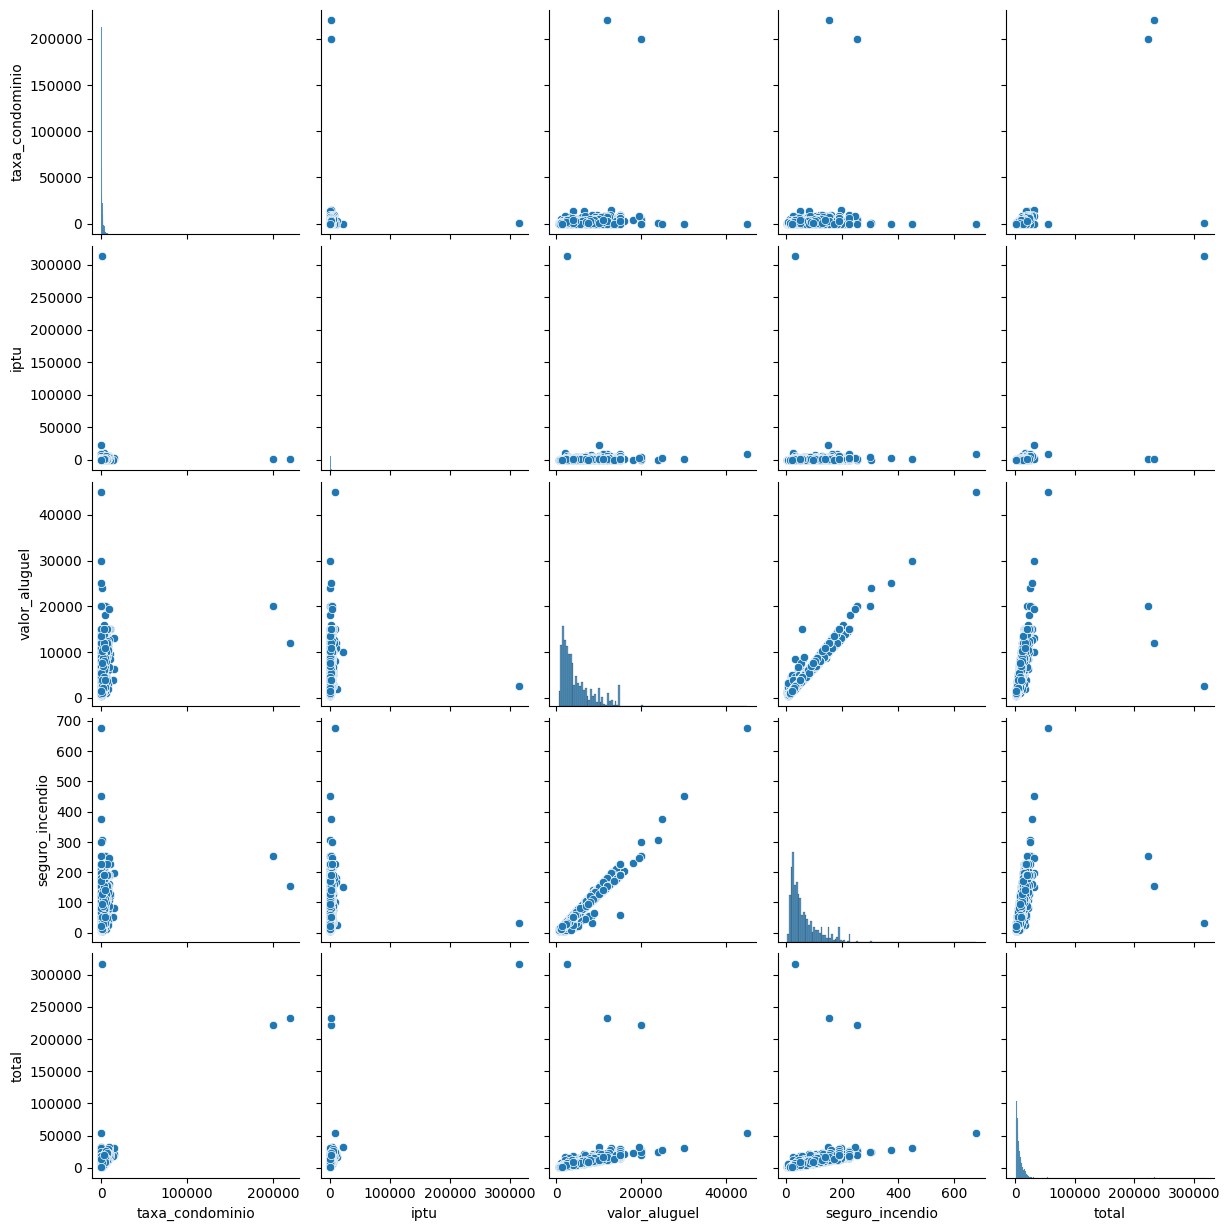

In [16]:
sns.pairplot(df[["taxa_condominio","iptu","valor_aluguel","seguro_incendio", "total"]])
plt.show()

### Como obtive essa base de dados do Kaggle, pretendo seguir um procedimento mais rigoroso em relação aos outliers. Vou examinar cada coluna individualmente e verificar a distribuição das variáveis antes de decidir como tratá-los.

- E vamos observar como os outliers podem prejudicar nossa análise e interpretação da distribuição dos dados

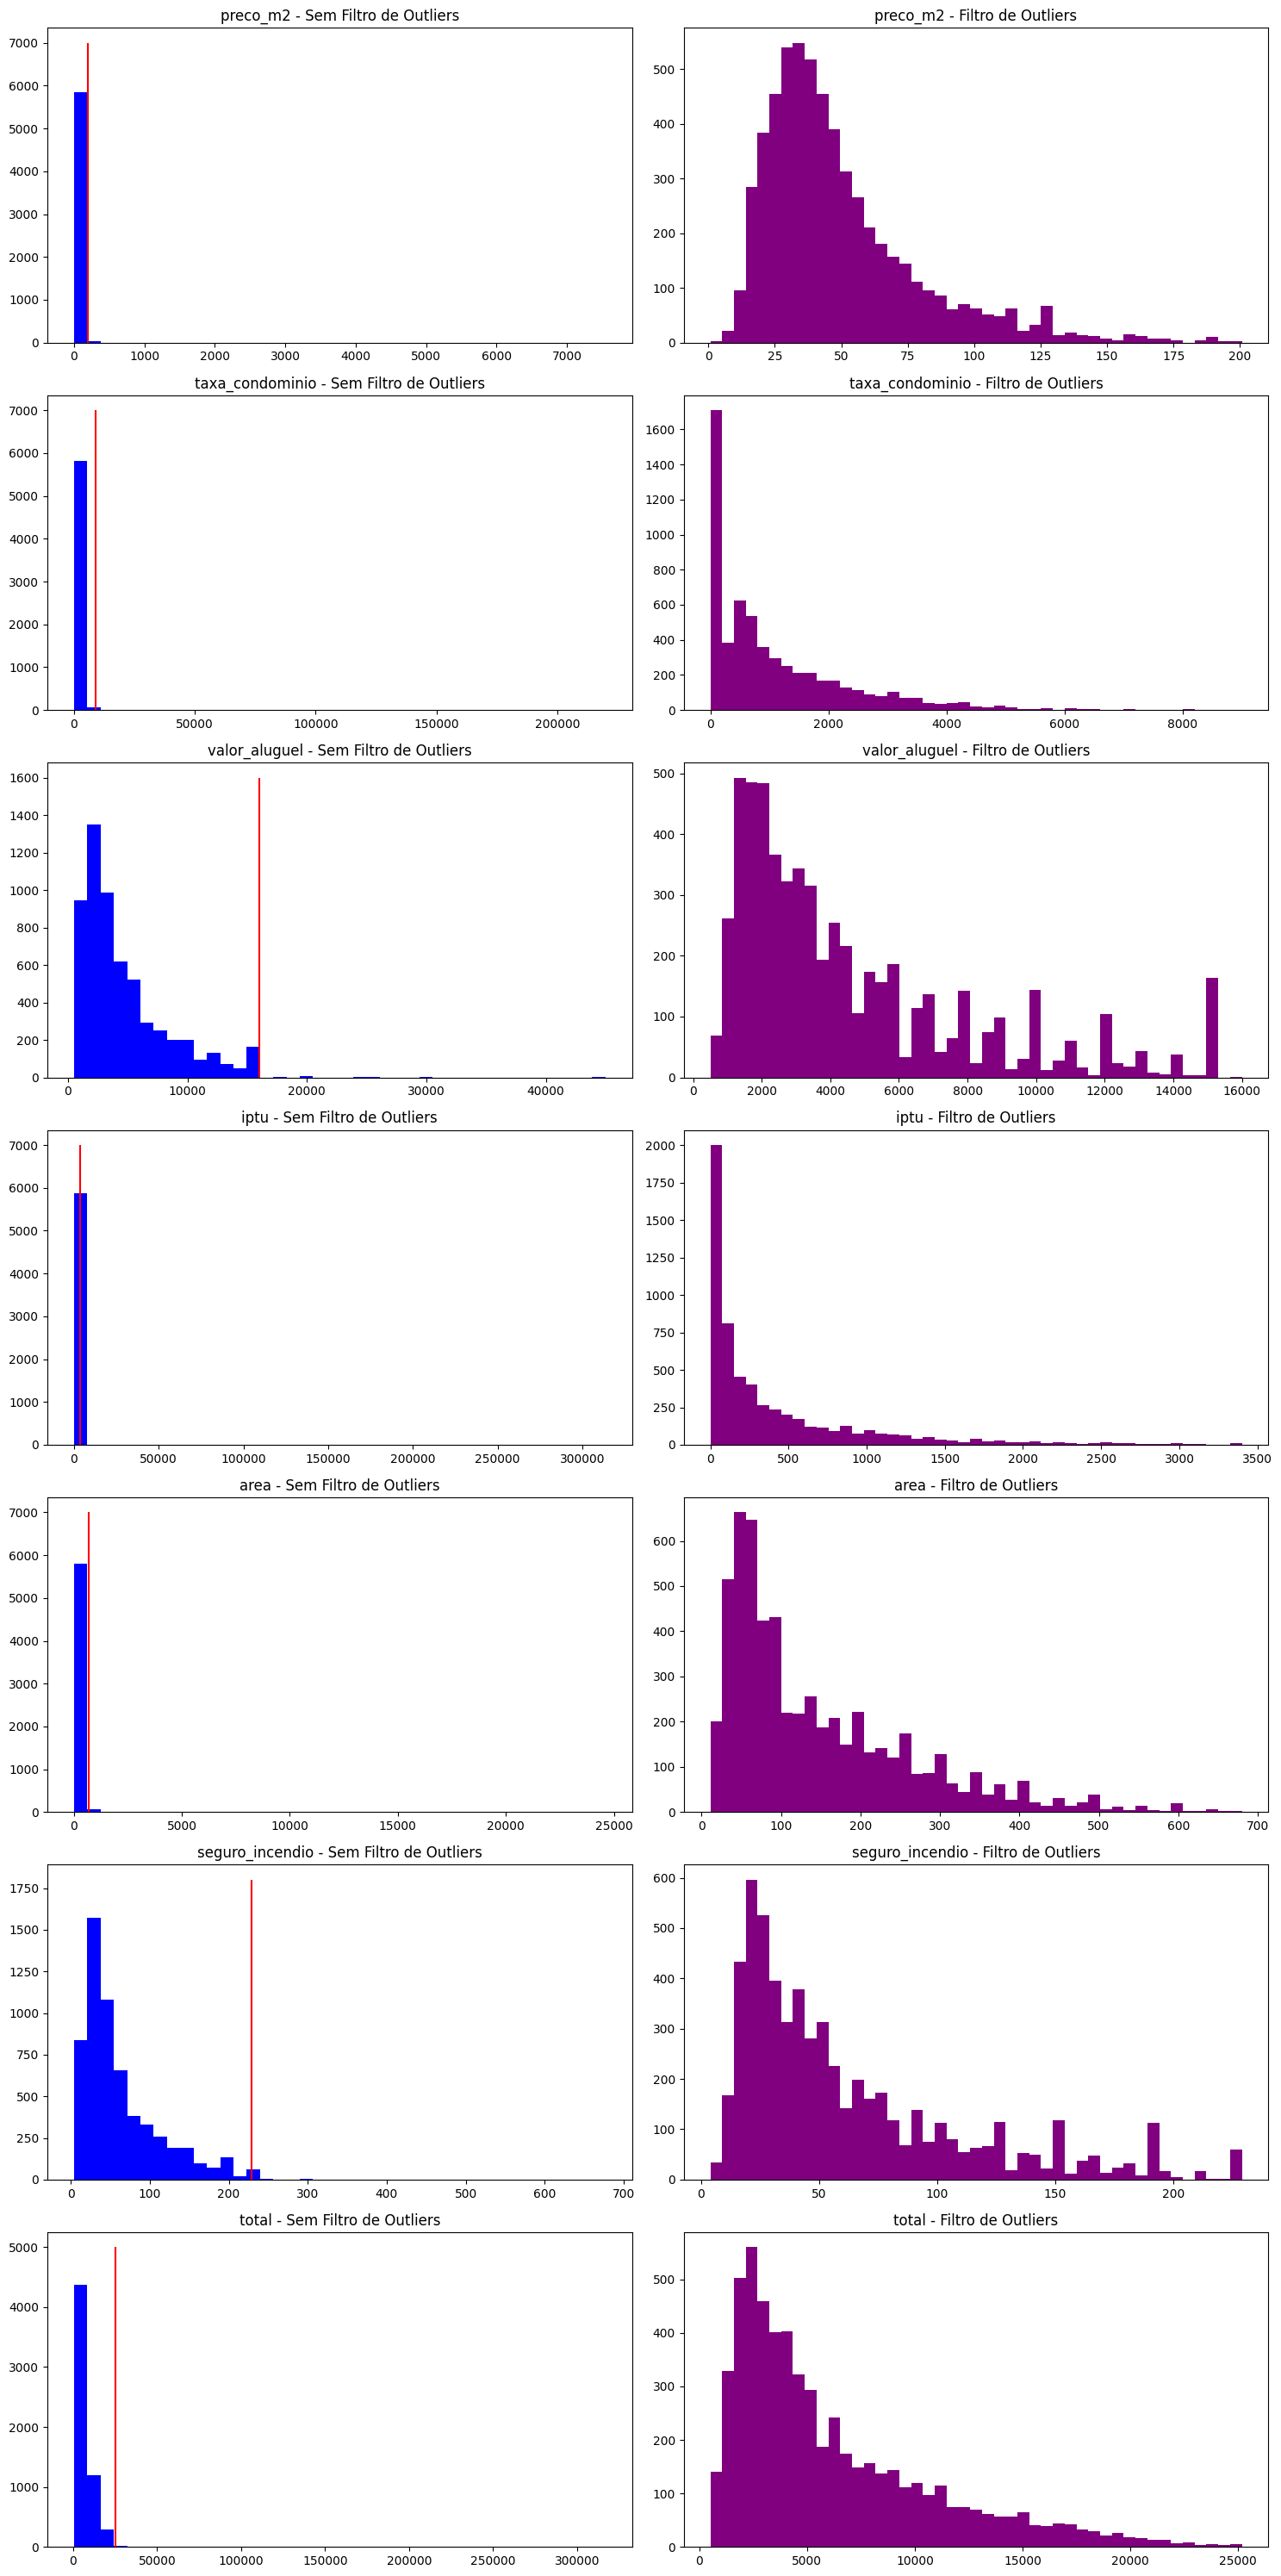

In [17]:
from scipy import stats
columns = ["preco_m2","taxa_condominio", "valor_aluguel", "iptu","area", "seguro_incendio", "total"]
value_z = [1.5, 2, 3.5 , 0.7, 1.5, 3.5, 2.5]

fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(15, 30))

for i, col in enumerate(columns):
    # Plotamos o histograma na esquerda
    axes[i][0].hist(df[col].dropna(), bins=40, color="b")
    
    # Obtemos a mascara booleana de possíveis outliers (de acordo com o valor de Z)
    mask = np.abs(stats.zscore(df[col].dropna())) < value_z[i]
    df_filtrado = df[col].dropna()[mask]
    
    # Plotamops o histograma na direita, já filtrado.
    axes[i][1].hist(df_filtrado, bins=45, color="purple")
    
    # Aproveitamos para plotar no esquerda, onde nós "cortamos" o histograma, para gerar o hist da direita
    ymax = axes[i][0].get_yticks()[-1]
    axes[i][0].vlines(x=max(df_filtrado), ymin=0, ymax=ymax, color="red")
    
    # Titulos dos gráficos
    axes[i][0].set_title("{} - Sem Filtro de Outliers".format(col))
    axes[i][1].set_title("{} - Filtro de Outliers".format(col))

plt.tight_layout()
plt.show()


### Aplicando o filtro para todas colunas em um novo dataframe.

In [18]:
# Aplicando os filtros para cada coluna
for col, z_value in zip(columns, value_z):
    # Calculando a máscara de valores dentro do limite de Z
    z_scores = np.abs(stats.zscore(df[col].dropna()))
    col_mask = z_scores < z_value
    
    # Atualizando a máscara geral com base na máscara da coluna atual
    mask = mask & col_mask

# Aplicando a máscara geral para filtrar o DataFrame original
df_filtrado = df[mask]

### Distribuição das demais variáveis: aqui podemos observar que a maioria das instâncias possui 3 quartos, um banheiro e uma vaga de estacionamento.

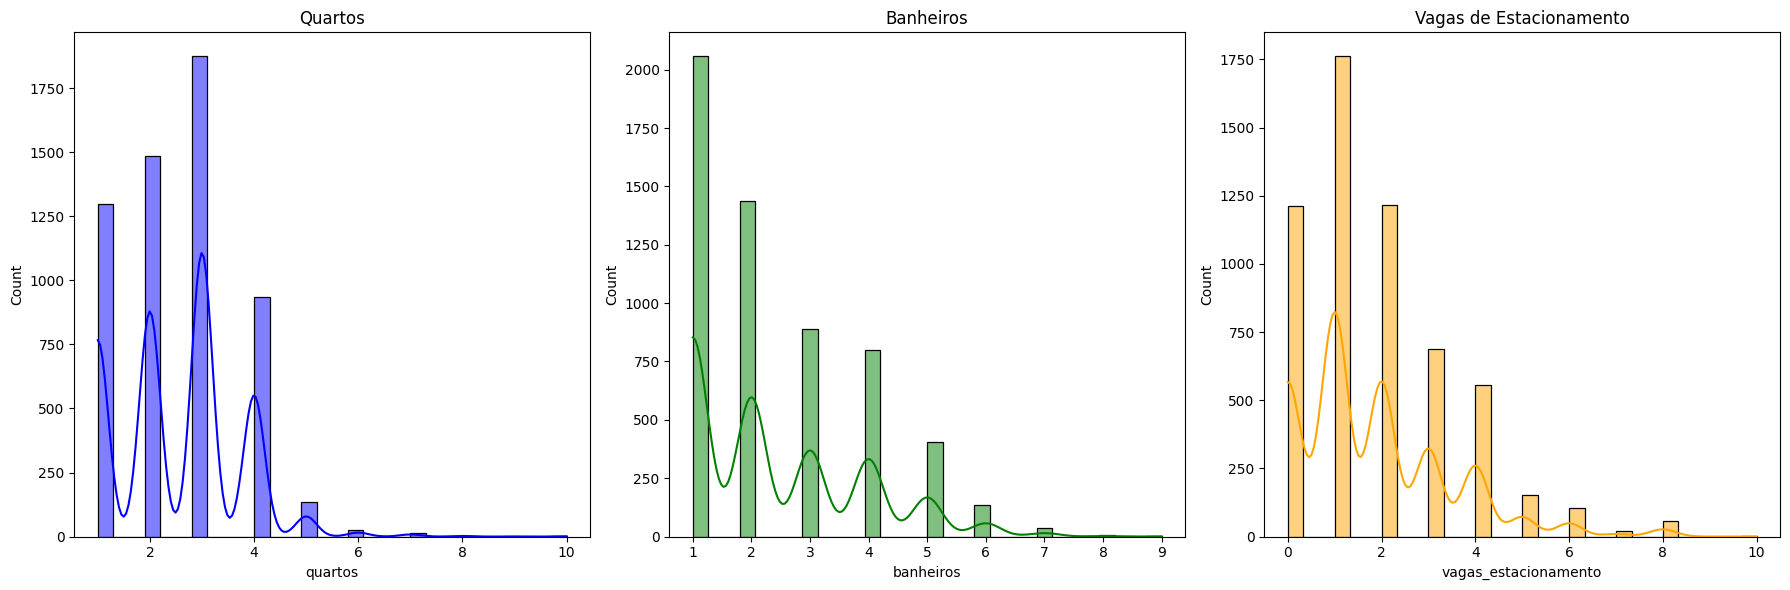

In [19]:
# Definindo o tamanho da figura.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotando histogramas para cada variável em um subplot separado
sns.histplot(df_filtrado["quartos"], kde=True, color='blue', bins=30, ax=axs[0])
sns.histplot(df_filtrado["banheiros"], kde=True, color='green', bins=30, ax=axs[1])
sns.histplot(df_filtrado["vagas_estacionamento"], kde=True, color='orange', bins=30, ax=axs[2])

# Adicionando título para cada subplot.
axs[0].set_title("Quartos")
axs[1].set_title("Banheiros")
axs[2].set_title("Vagas de Estacionamento")

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()


### Ao filtrar alguns dados que podem influenciar muito nossa análise, por exemplo, um imóvel com 100 metros quadrados ter 7 quartos e 4 banheiros, algo muito improvável de ser possível, vamos tratar isso como uma anormalidade.

In [20]:
df_quarto = df.loc[(df["quartos"] > 5) & (df["area"] < 150)]
df_quarto

,area,quartos,banheiros,vagas_estacionamento,mobiliado,taxa_condominio,valor_aluguel,iptu,seguro_incendio,total,preco_m2
20,100,7,4,0,nao mobiliado,0,3800,118,58,3976,39.760000
3370,110,6,5,7,nao mobiliado,0,9810,1000,148,10960,99.636364
10150,100,6,7,5,nao mobiliado,0,10660,2167,161,12990,129.900000


In [21]:
df_banheiro = df.loc[(df["banheiros"] > 5) & (df["area"] < 150)]
df_banheiro

,area,quartos,banheiros,vagas_estacionamento,mobiliado,taxa_condominio,valor_aluguel,iptu,seguro_incendio,total,preco_m2
8380,43,2,7,2,nao mobiliado,257,2270,0,29,2556,59.44186
10150,100,6,7,5,nao mobiliado,0,10660,2167,161,12990,129.90000


In [22]:
df_estacionamento = df.loc[(df["vagas_estacionamento"] > 5) & (df["area"] < 120)]
df_estacionamento

,area,quartos,banheiros,vagas_estacionamento,mobiliado,taxa_condominio,valor_aluguel,iptu,seguro_incendio,total,preco_m2
1688,100,3,2,6,nao mobiliado,0,7500,1000,113,8613,86.130000
3370,110,6,5,7,nao mobiliado,0,9810,1000,148,10960,99.636364
9948,70,1,2,6,nao mobiliado,0,3290,417,50,3757,53.671429


### Eliminando as linhas com anomalias.

In [23]:
df_filtrado = df_filtrado.drop([20,3370, 10150, 8380, 1688, 3370, 9948])

### Veja como nossa distribuição melhorou em relação ao que estava antes e como a identificação e remoção dos outliers são importantes para uma análise de dados. Além disso, observamos uma melhoria no comportamento das variáveis em relação à nossa variável alvo (target).

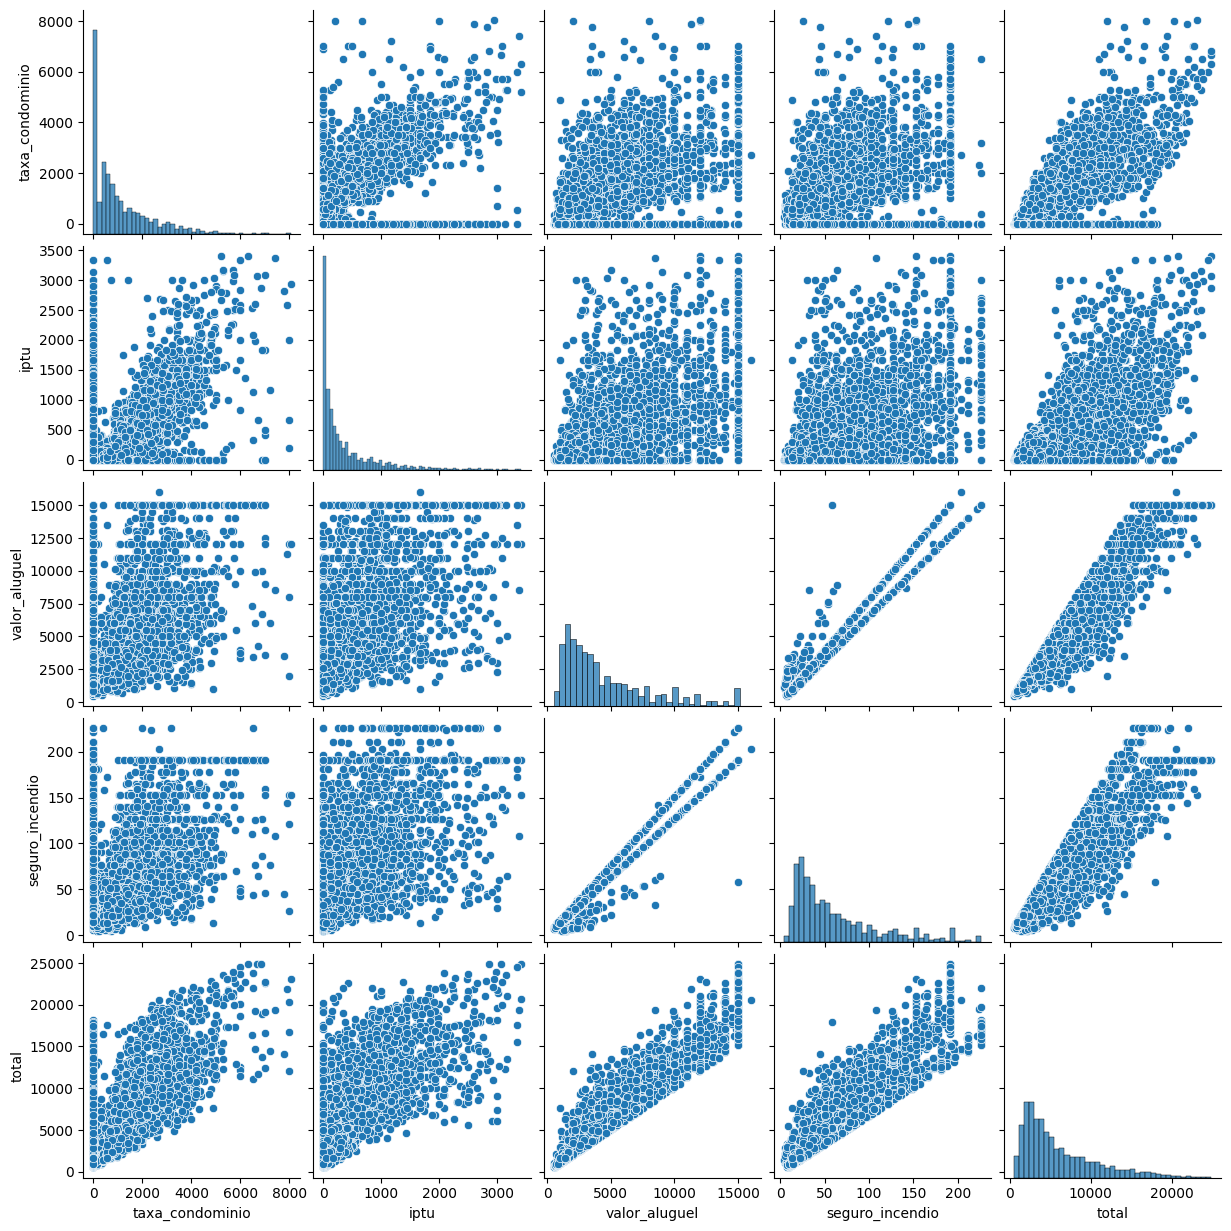

In [24]:
sns.pairplot(df_filtrado[["taxa_condominio", "iptu", "valor_aluguel", "seguro_incendio", "total", "mobiliado"]])
plt.show()

### Quantidade de dados filtrados.

In [25]:
quantidade_retirada = df.shape[0] - df_filtrado.shape[0]

print("Quantidade de dados retirados:", quantidade_retirada)

Quantidade de dados retirados: 122


### Vou observar se a coluna 'mobiliado' pode ser uma feature importante para o nosso futuro modelo.

### Porcentagem de imóveis mobiliados

In [26]:
df_filtrado["mobiliado"].value_counts(1)

mobiliado
nao mobiliado    0.729748
mobiliado        0.270252
Name: proportion, dtype: float64

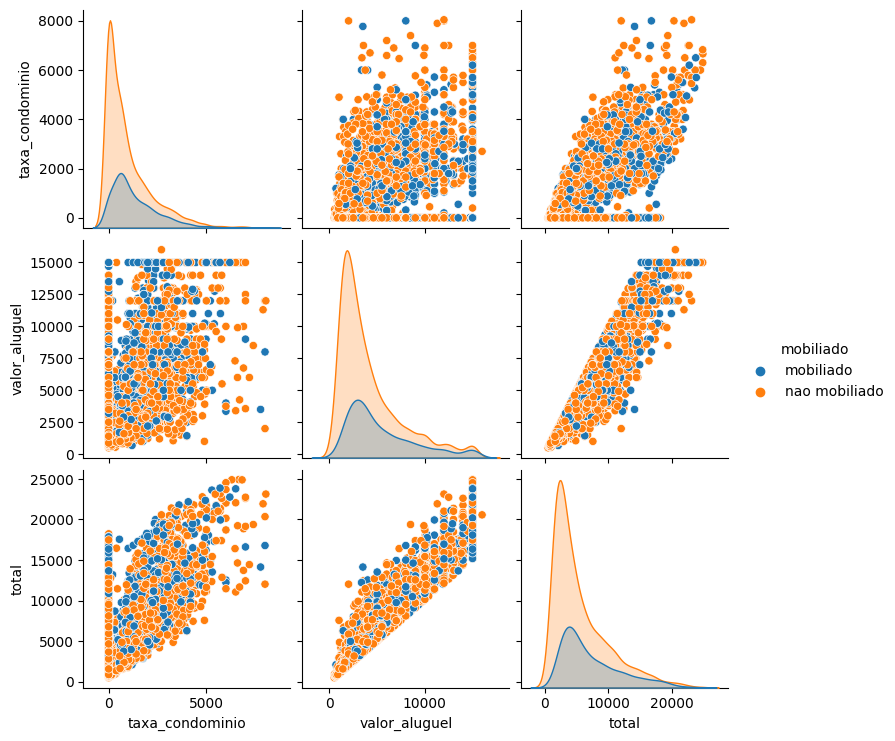

In [27]:
# Crie um pairplot com a nova coluna "mobiliado" como hue
sns.pairplot(df_filtrado[["taxa_condominio", "valor_aluguel", "total", "mobiliado"]], hue="mobiliado")

plt.show()

### Nesse gráfico, podemos observar como um imóvel mobiliado influencia o valor do aluguel, tornando-o mais caro. Também podemos visualizar a distribuição dos aluguéis em relação a essa variável.

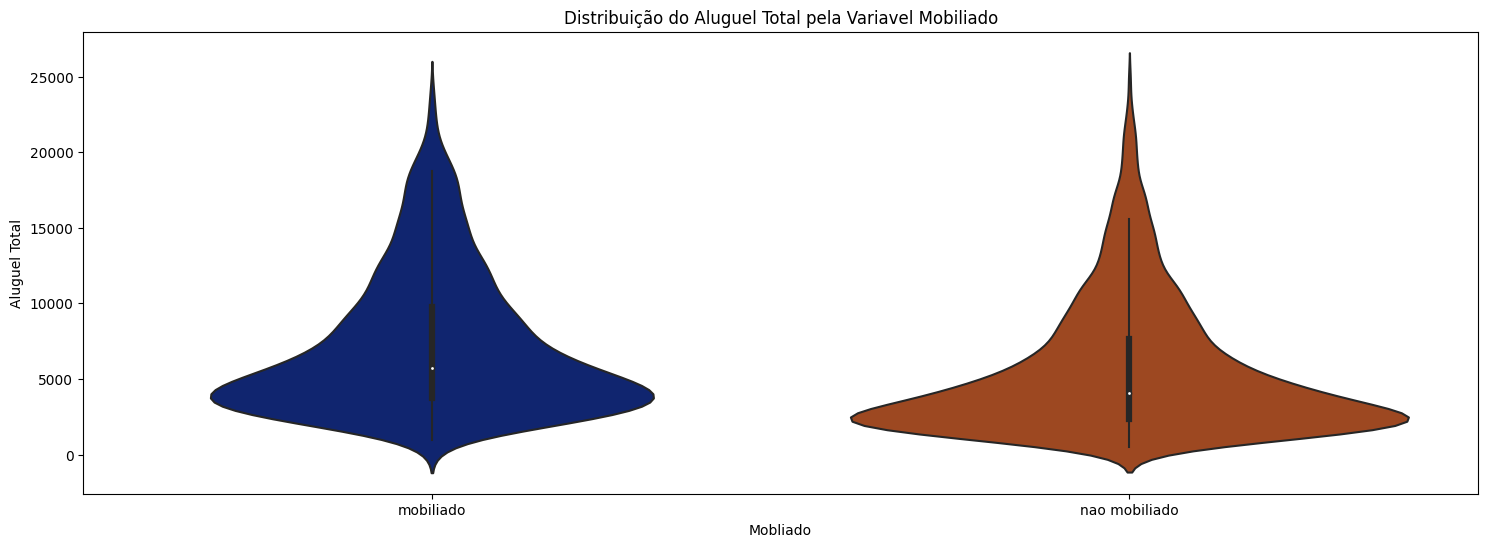

In [28]:
#Tamanho do gráfico
plt.figure(figsize=(18, 6))

sns.violinplot(x="mobiliado", y="total",palette="dark", data=df_filtrado)

#Título e labels
plt.title("Distribuição do Aluguel Total pela Variavel Mobiliado")
plt.xlabel("Mobliado")
plt.ylabel("Aluguel Total")

#Mostrar o grafico
plt.show()

### Transformando a coluna "mobiliado" em uma variável numérica para o nosso modelo de regressão.

In [29]:
mapeamento = {'mobiliado': 1, 'nao mobiliado': 0}
df_filtrado["mobiliado"] = df_filtrado["mobiliado"].map(mapeamento)
df_filtrado["mobiliado"].value_counts()

mobiliado
0    4207
1    1558
Name: count, dtype: int64

In [30]:
df_filtrado = df_filtrado.drop("valor_aluguel", axis=1)
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5765 entries, 0 to 10691
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   area                  5765 non-null   int64  
 1   quartos               5765 non-null   int64  
 2   banheiros             5765 non-null   int64  
 3   vagas_estacionamento  5765 non-null   int64  
 4   mobiliado             5765 non-null   int64  
 5   taxa_condominio       5765 non-null   int64  
 6   iptu                  5765 non-null   int64  
 7   seguro_incendio       5765 non-null   int64  
 8   total                 5765 non-null   int64  
 9   preco_m2              5765 non-null   float64
dtypes: float64(1), int64(9)
memory usage: 495.4 KB


# Os coeficientes de correlação variam de -1 a 1 e indicam a força e a direção da relação linear entre as variáveis
- Um coeficiente de correlação próximo a 1 indica uma forte correlação positiva, o que significa que as variáveis tendem a aumentar juntas.
- Um coeficiente de correlação próximo a -1 indica uma forte correlação negativa, o que significa que uma variável tende a aumentar enquanto a outra diminui.
- Um coeficiente de correlação próximo a 0 indica uma correlação fraca ou inexistente entre as variáveis.

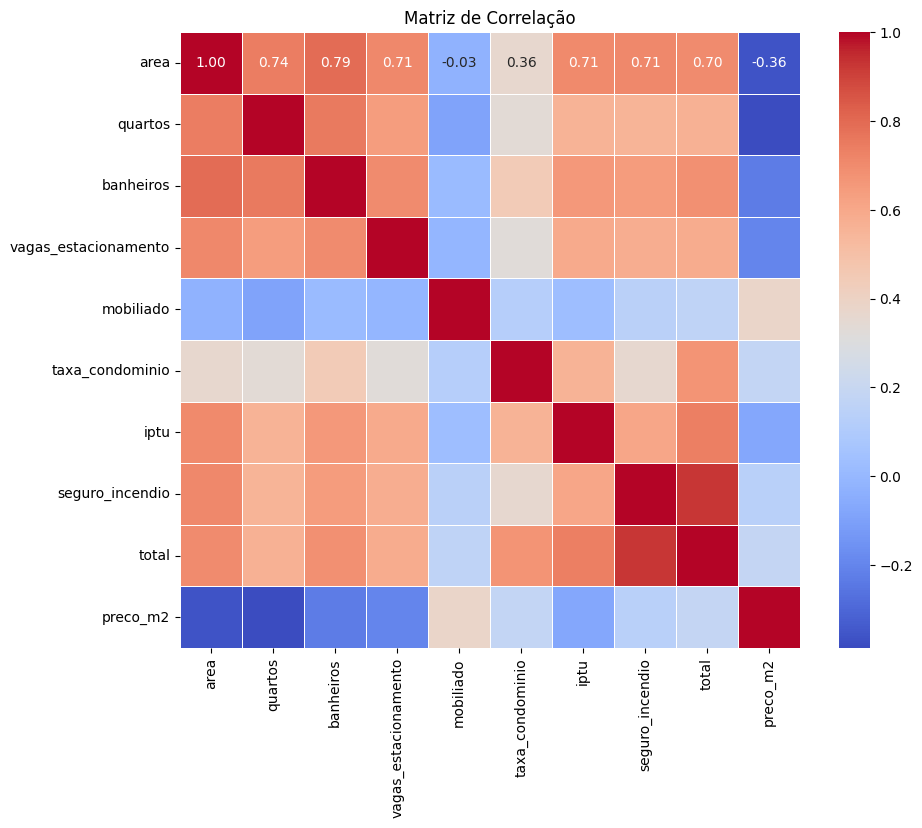

In [31]:
# Calcula a matriz de correlação
correlation_matrix = df_filtrado.corr()

# Plota o mapa de calor da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlação")
plt.show()

 <div align="center">
 <h1> Padronização e normalização dos dados &nbsp; </h1>
 </div>

### Padronização

- Padronização e normalização de dados são técnicas importantes em pré-processamento de dados usadas para colocar variáveis em uma escala comum, o que pode trazer vários benefícios para análises e modelagem de dados, principalmente quando em diferentes escalas. A padronização transforma os dados para ter uma média zero e um desvio padrão de 1, enquanto a normalização ajusta os dados para um intervalo específico, geralmente entre 0 e 1. Como é um processo bem rápido, irie testar os dois, pra ver qual o modelo se sai melhor.

In [32]:
#Padronização
from sklearn.preprocessing import StandardScaler
obj_padronizacao = StandardScaler().fit(df_filtrado)
df_padronizado=obj_padronizacao.transform(df_filtrado)

df_padronizado = pd.DataFrame(df_padronizado)
df_padronizado.columns = ['area', 'quartos', 'banheiros', 'vagas_estacionamento', 
                          'mobiliado', 'taxa_condominio', 'iptu', 
                          'seguro_incendio', 'total', 'preco_m2']

#Dataframe padronizado
df_padronizado.head()

,area,quartos,banheiros,vagas_estacionamento,mobiliado,taxa_condominio,iptu,seguro_incendio,total,preco_m2
0,-0.651706,-0.463397,-0.978427,-0.506380,1.643246,0.817767,-0.329541,-0.392088,-0.090059,0.996189
1,1.490851,1.288396,1.093050,-1.127899,-0.608552,0.108679,2.498497,0.057157,0.428725,-0.830360
2,-1.037366,-1.339294,-0.978427,-1.127899,-0.608552,-0.875027,-0.671332,-1.055260,-1.143488,-0.549013
3,1.970784,0.412500,0.402558,3.222739,-0.608552,-0.875027,0.815272,1.297930,0.645050,-0.866637
4,0.573837,1.288396,1.093050,1.358180,-0.608552,0.972701,2.470933,-0.413481,0.270116,-0.528826


### Para mostrar essa diferença, vou plotar o dataframe antes da padronização. Observe como os dados estão em escalas totalmente diferentes. Agora, imagine um algoritmo recebendo esses dados. Como será o resultado?

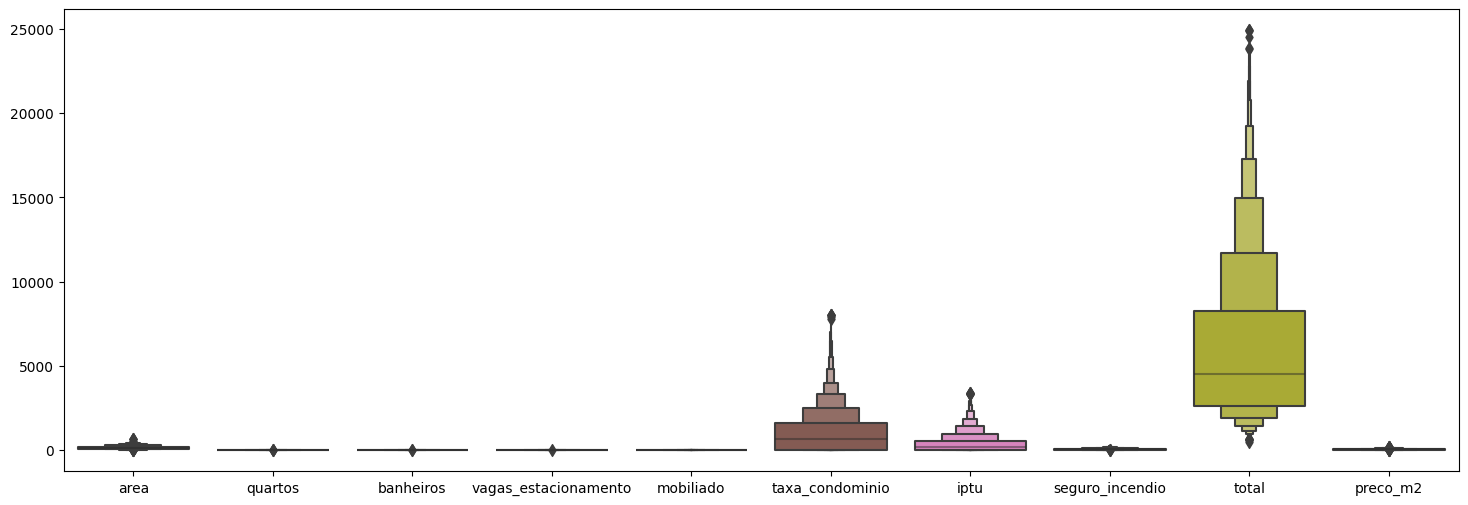

In [33]:
plt.figure(figsize=(18,6))
ax= sns.boxenplot(data= df_filtrado)

### Agora, observe a diferença de escala em que os dados estão. É muito mais fácil identificar até mesmo outliers. É assim que o algoritmo espera receber os dados.

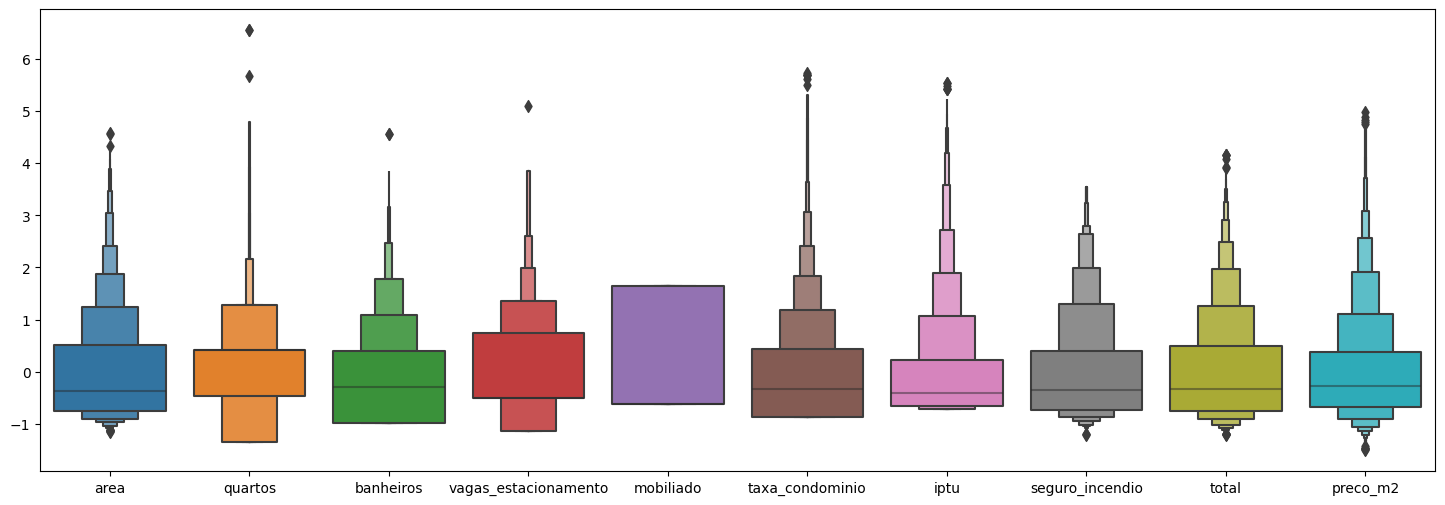

In [34]:
plt.figure(figsize=(18,6))
ax= sns.boxenplot(data= df_padronizado)

### Normalização dos dados
 

### Veja que os números se tornaram arrays NumPy. Logo, vou convertê-los novamente para um DataFrame.

In [35]:
#Normalização
from sklearn.preprocessing import MinMaxScaler
obj_normalização= MinMaxScaler().fit(df_filtrado)
df_normalizado = obj_normalização.transform(df_filtrado)
df_normalizado

array([[0.08682635, 0.11111111, 0.        , ..., 0.17117117, 0.20940906,
        0.38578007],
       [0.46107784, 0.33333333, 0.375     , ..., 0.26576577, 0.30591755,
        0.10357561],
       [0.01946108, 0.        , 0.        , ..., 0.03153153, 0.01344152,
        0.14704418],
       ...,
       [0.20658683, 0.22222222, 0.25      , ..., 0.75675676, 0.53938202,
        0.44124131],
       [0.40868263, 0.33333333, 0.375     , ..., 0.84234234, 0.7684616 ,
        0.32112981],
       [0.10179641, 0.11111111, 0.        , ..., 0.08108108, 0.04421769,
        0.07768059]])

### Veja como transformei o array em um novo Dataframe

In [36]:
df_normalizado = pd.DataFrame(df_normalizado)
df_normalizado.columns = ['area', 'quartos', 'banheiros', 'vagas_estacionamento', 
                          'mobiliado', 'taxa_condominio', 'iptu', 
                          'seguro_incendio', 'total', 'preco_m2']
df_normalizado.head()

,area,quartos,banheiros,vagas_estacionamento,mobiliado,taxa_condominio,iptu,seguro_incendio,total,preco_m2
0,0.086826,0.111111,0.000,0.1,1.0,0.256745,0.062059,0.171171,0.209409,0.385780
1,0.461078,0.333333,0.375,0.0,0.0,0.149198,0.514706,0.265766,0.305918,0.103576
2,0.019461,0.000000,0.000,0.0,0.0,0.000000,0.007353,0.031532,0.013442,0.147044
3,0.544910,0.222222,0.250,0.7,0.0,0.000000,0.245294,0.527027,0.346160,0.097971
4,0.300898,0.333333,0.375,0.4,0.0,0.280244,0.510294,0.166667,0.276412,0.150163


### Dados normalizados, com visualização do boxplot.

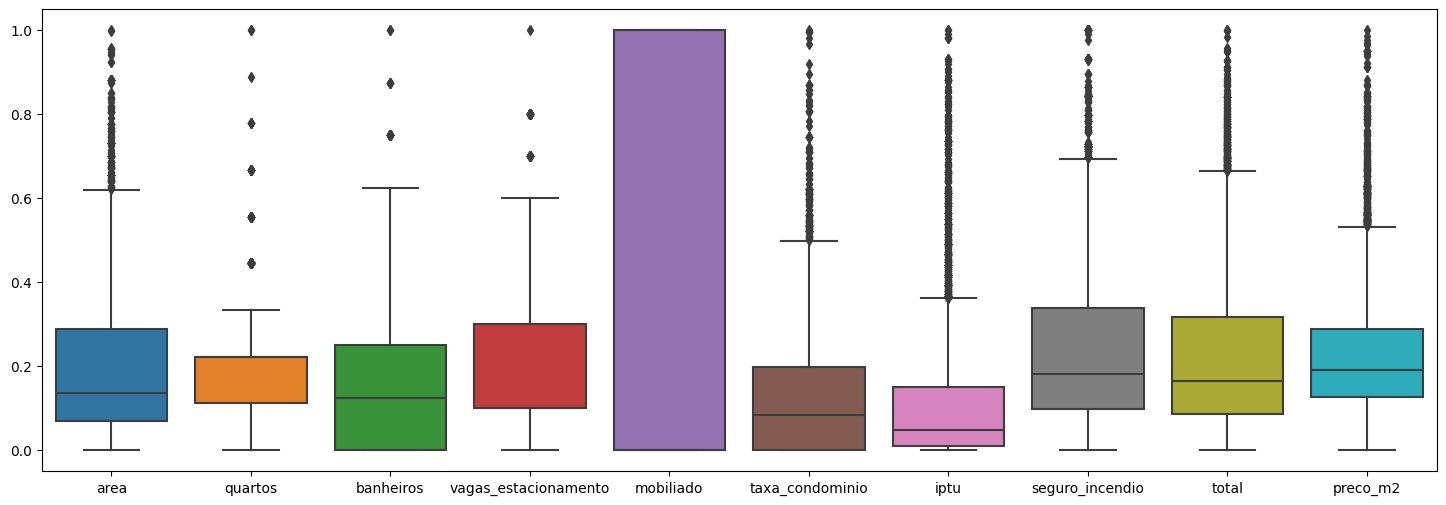

In [37]:
plt.figure(figsize=(18,6))
ax= sns.boxplot(data= df_normalizado)

### Separando os dados em dois dataframes, para treino e teste.

In [38]:
X = df_padronizado["total"]
y = df_padronizado.drop("total", axis=1)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3)

#quantidade de dados de treino
X_train.size 


4035

### O método reshape(-1, 1) é usado para modificar a forma (shape) dos dados .Essa operação é comum em aprendizado de máquina quando você está trabalhando com uma única variável independente (ou feature) e precisa ajustar a forma dos dados para a entrada de alguns modelos de aprendizado de máquina, como modelos lineares ou de regressão.

In [39]:
X_train = X_train.values.reshape(-1,1)
X_test= X_test.values.reshape(-1,1)

### Treino e teste do modelo dos dados padronizados.

In [40]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

### Desempenho do modelo com os dados padronizados

In [42]:
from sklearn import metrics
def r2_adjusted_score(r2, y, X):
    n = len(y)
    k = X.shape[1] 
    return (r2 - ((k-1)/(n-k)) * (1-r2))

mae = metrics.mean_absolute_error(y_test, predictions).round(4)
mse = metrics.mean_squared_error(y_test, predictions).round(4)
r2 = metrics.r2_score(y_test, predictions).round(4)
r2_adjusted = r2_adjusted_score(r2, y_test, X_test).round(4)
modelo_metricas = pd.DataFrame([{'Modelo': 'LinearRegression','MAE': mae, 'MSE': mse, 'R²': r2, 'R² Adjusted': r2_adjusted}])
modelo_metricas

,Modelo,MAE,MSE,R²,R² Adjusted
0,LinearRegression,0.5584,0.6079,0.3876,0.3876


### Separando dados de teste e treino

In [43]:
X_dados = df_normalizado["total"]
y_dados = df_normalizado.drop("total", axis=1)
X_treino, X_teste, y_treino, y_teste= train_test_split(X_dados, y_dados, test_size=0.3)
X_train.size

4035

### Reshape

In [44]:
X_treino = X_treino.values.reshape(-1,1)
X_teste = X_teste.values.reshape(-1,1)

### Treino do modelo de dados

In [45]:
scaler = StandardScaler()
scaler.fit(X_train)

X_treino = scaler.transform(X_treino)
X_teste = scaler.transform(X_teste)
regressor2 = LinearRegression()
regressor2.fit(X_train, y_train)
predictions2 = regressor2.predict(X_teste)

#### Desempenho do modelo com os dados normalizados.

In [46]:
def r2_adjusted_score(r2, y, X):
    n = len(y) 
    k = X.shape[1]
    return (r2 - ((k-1)/(n-k)) * (1-r2))
mae = metrics.mean_absolute_error(y_teste, predictions2).round(4)
mse = metrics.mean_squared_error(y_teste, predictions2).round(4)
r2 = metrics.r2_score(y_teste, predictions2).round(4)
r2_adjusted = r2_adjusted_score(r2, y_teste, X_teste).round(4)
modelo_metricas2 = pd.DataFrame([{'Modelo': 'LinearRegression','MAE': mae, 'MSE': mse, 'R²': r2, 'R² Adjusted': r2_adjusted}])
modelo_metricas2

,Modelo,MAE,MSE,R²,R² Adjusted
0,LinearRegression,0.1182,0.0456,0.11,0.11
